# PIK3CA: Effects of Hotspot Mutation on IRS2

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

### Import CPTAC

In [3]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [4]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [5]:
protein = 'IRS1'
gene = 'PIK3CA'

## Extract the data for hotspot mutations only 

In [6]:
#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [7]:
p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
#print(p10_mutations)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)
print(len(p10_mutations.loc[(p10_mutations['Within_Hotspot'] == True)]))

19


## Hotspot mutation vs non-hotspot mutation

In [8]:
in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
print(ttest)

Ttest_indResult(statistic=-0.1811143291128672, pvalue=0.8570734994915308)


## Hotspot mutation vs other mutations and wildtype

In [9]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.6714134122839353, pvalue=0.5035367810301701)


## All mutations vs wildtype

In [10]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.03423533120962, pvalue=0.3035716066390899)


## Hotspot mutation v wildtype

In [11]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.890843404844897, pvalue=0.3761090199360049)


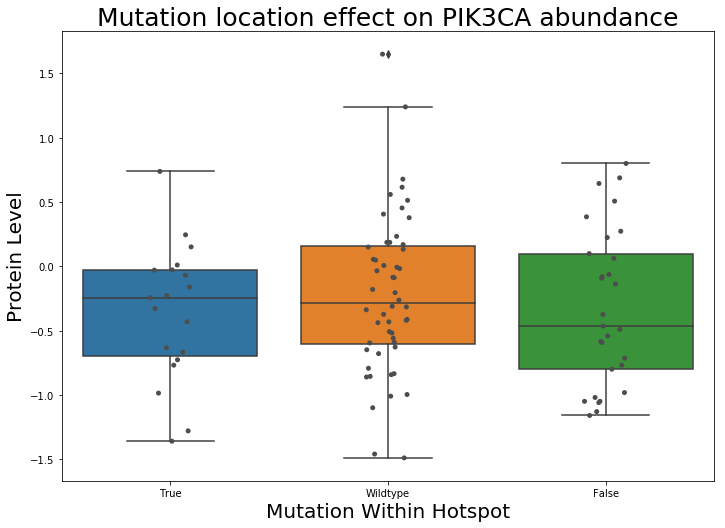

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on PIK3CA abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

# Phosphoproteomic Abundance

In [13]:
phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
phos_mutations['Within_Hotspot'] = False
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True

phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
#print(phos_mutations)


phos_mutations = phos_mutations.loc[phos_mutations['Patient_Type'] == 'Tumor']
#phos_mutations = phos_mutations.dropna(axis = 0)
#print(phos_mutations)
phos_sites = list(phos_mutations)
phos_sites = phos_sites[:(len(phos_sites) - 3)]

## Hotspot mutation vs non-hotspot mutation

In [14]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == False]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site)  
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))


print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


## Hotspot mutation vs other mutations and wildtype

In [15]:
p_values = []
site_names = []


for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] != True]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site)  
    
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))
    
print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


## All mutations vs wildtype

In [16]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Wildtype']
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 

    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))
    
print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


## Hotspot mutation v wildtype

In [17]:
p_values = []
site_names = []


for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))
    
print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


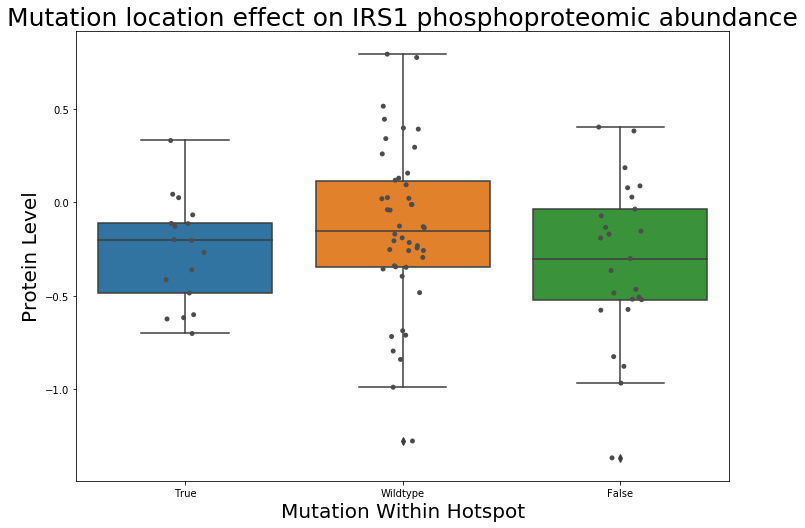

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1100', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1100', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

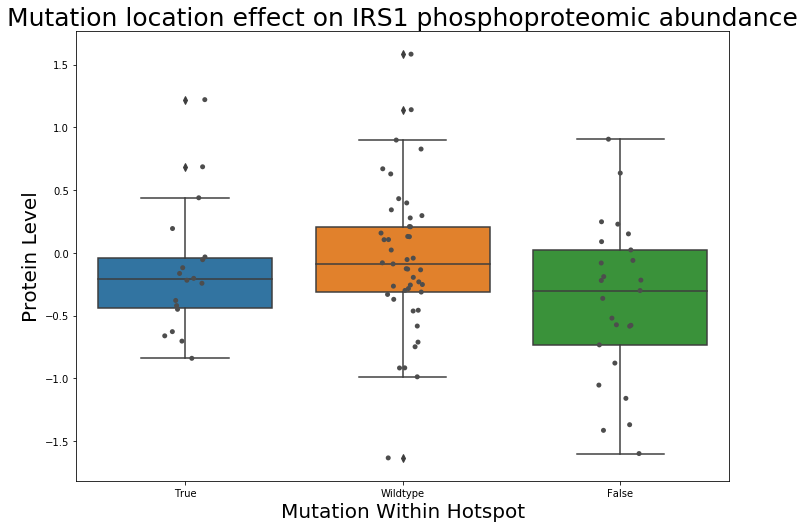

In [22]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1101', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1101', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

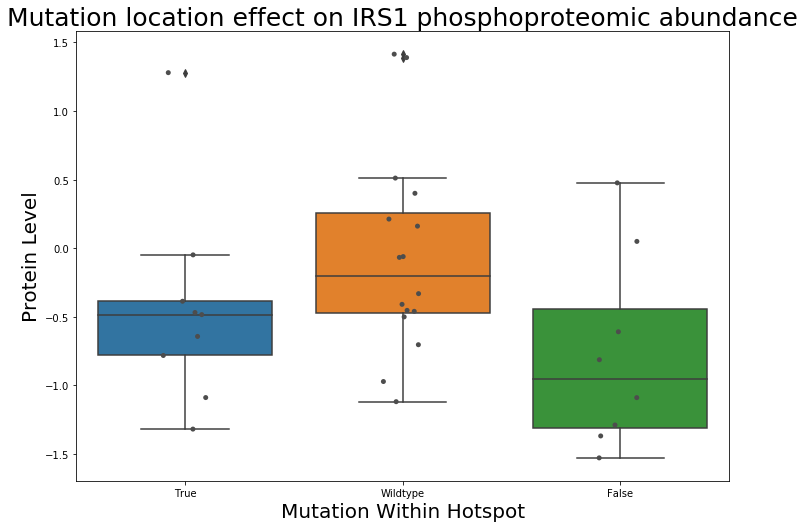

In [19]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S766', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S766', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

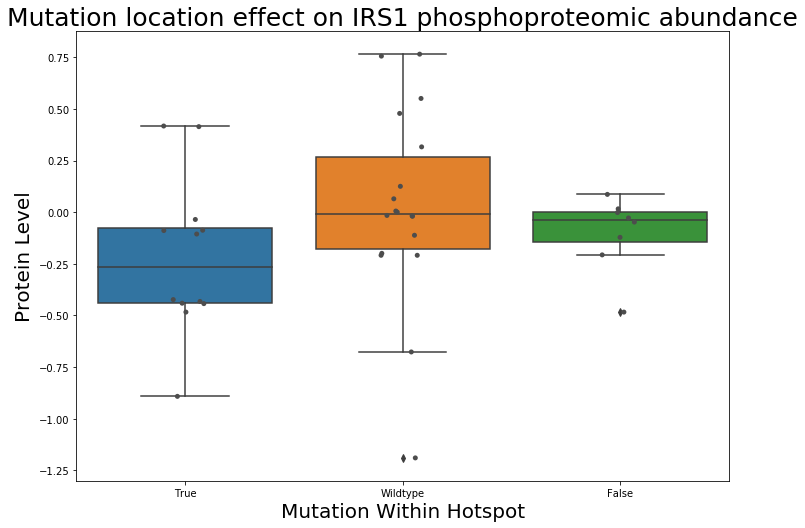

In [20]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1133', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S1133', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

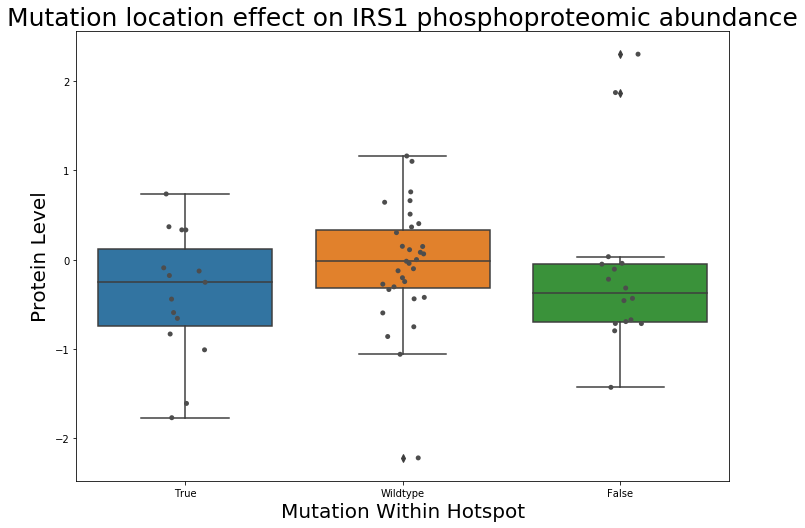

In [21]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S672', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS1-S672', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()